# **MODELO PREDICTIVO EN BASE A DATOS DE 2024**
# Ricardo Villalobos U00144370

In [1]:
#Para manejo de datos
import pandas as pd
import numpy as np
#Para el modelo IA predictivo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

***Cargar archivos desde el drive***


In [2]:
#Adjuntar el dataset desde el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Cargando y leyendo el dataset***

In [3]:
# Cargar el dataset
data = pd.read_csv('/content/drive/MyDrive/Ai_model_LOL/2024_LoL_esports_match_data_from_OraclesElixir.csv', low_memory=False)

# Equipos que se van a enfrentar
equipos_interes = [
    "LNG Esports", "Weibo Gaming",
    "Hanwha Life Esports", "Bilibili Gaming",
    "Top Esports", "T1",
    "Gen.G", "FlyQuest"
]

# Filtrar el dataset
data_filtrada = data[
    (data['teamname'].isin(equipos_interes)) & #Solo equipos de interes
    (data['position'] == "team")               #Solo la información del desempeño total del equipo
].copy()

# Contar el número de partidas disputadas entre los equipos de interes
partidas_por_equipo = data_filtrada['teamname'].value_counts()
print(partidas_por_equipo)

# Seleccionar características relevantes para la predicción
features = [
    'teamkills', 'teamdeaths',
]

# Asegurarse de que todas las características existen en el dataset
features = [f for f in features if f in data_filtrada.columns]

teamname
T1                     157
Top Esports            126
Bilibili Gaming        125
Gen.G                  121
Weibo Gaming           115
Hanwha Life Esports    112
LNG Esports             97
FlyQuest                74
Name: count, dtype: int64


**HISTORIAL DE PARTIDAS JUGADOS ENTRE ELLOS:**

*   T1                     157
*   Top Esports            126
*   Bilibili Gaming        125
*   Gen.G                  121
*   Weibo Gaming           115
*   Hanwha Life Esports    112
*   LNG Esports             97
*   FlyQuest                74

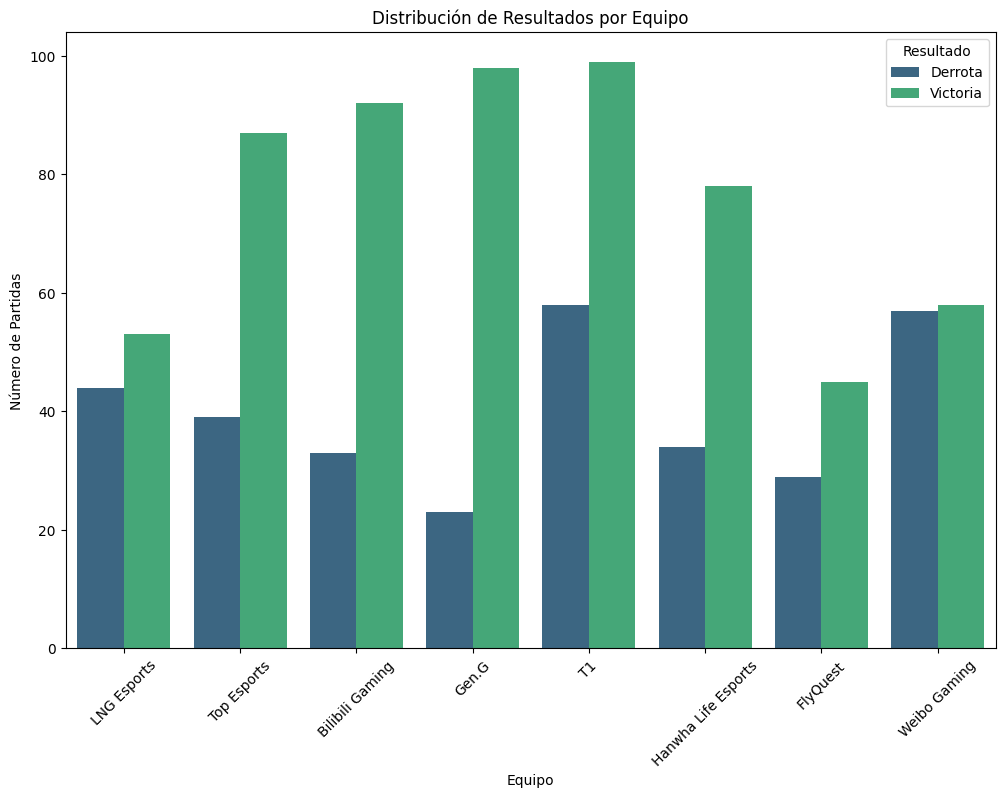

<Figure size 1600x1200 with 0 Axes>

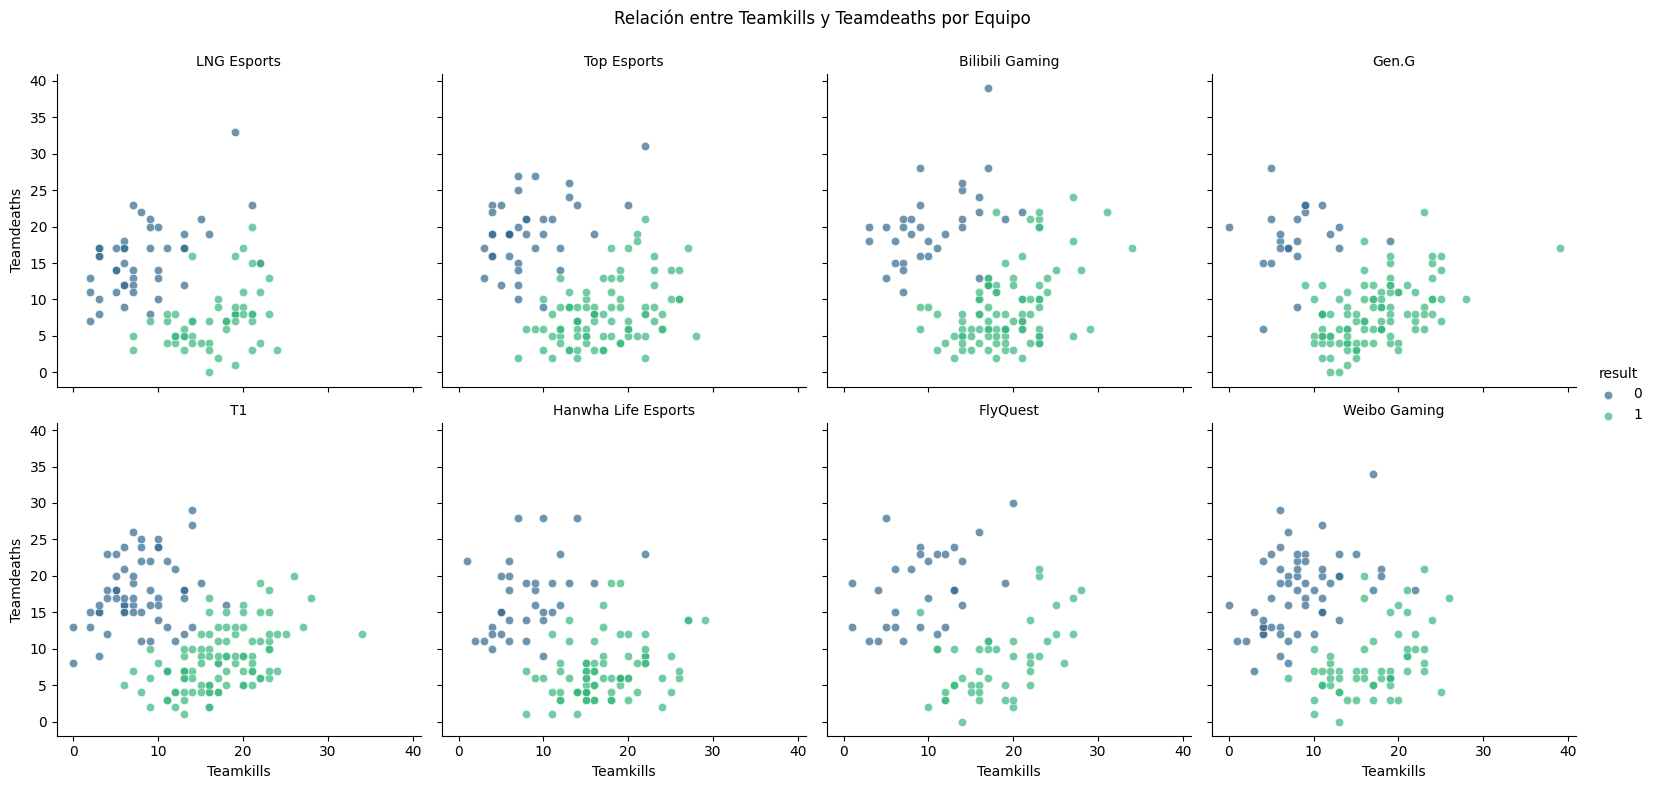

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de conteo de resultados por equipo
plt.figure(figsize=(12, 8))
sns.countplot(x='teamname', hue='result', data=data_filtrada, palette='viridis')
plt.title('Distribución de Resultados por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Número de Partidas')
plt.xticks(rotation=45)
plt.legend(title='Resultado', labels=['Derrota', 'Victoria'])
plt.show()

# Gráfico de dispersión entre teamkills y teamdeaths por equipo
plt.figure(figsize=(16, 12))
g = sns.FacetGrid(data_filtrada, col='teamname', hue='result', col_wrap=4, palette='viridis', height=4, aspect=1)
g.map(sns.scatterplot, 'teamkills', 'teamdeaths', alpha=0.7)
g.add_legend()
g.set_axis_labels('Teamkills', 'Teamdeaths')
g.set_titles(col_template='{col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Relación entre Teamkills y Teamdeaths por Equipo')
plt.show()



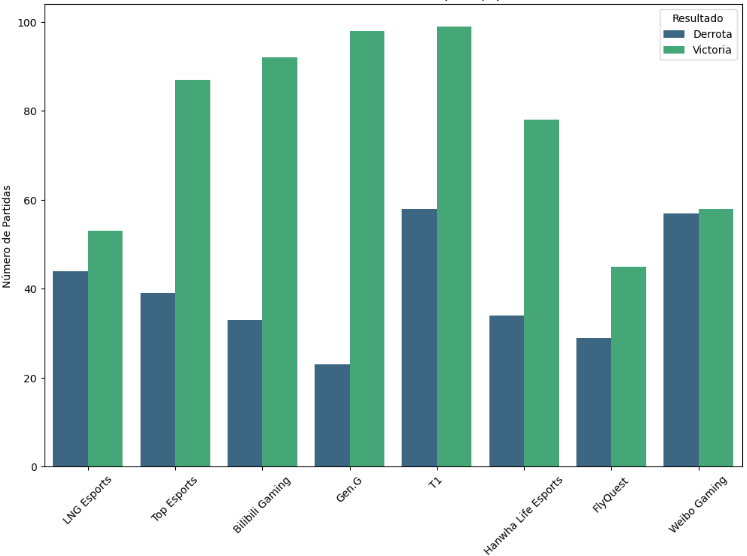

***Troceado y pre-procesamiento de datos***

In [5]:
X = data_filtrada[features]
y = data_filtrada['result']  #result = 0 en partidas perdidas y 1 en partidas ganadas


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ***Entrenamiento del modelo***

In [6]:
# Crear y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Derrota', 'Victoria']))

# Importancia de las características
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nImportancia de las características:")
print(feature_importance)


Precisión del modelo: 0.95

Informe de clasificación:
              precision    recall  f1-score   support

     Derrota       0.91      0.94      0.93        67
    Victoria       0.97      0.95      0.96       119

    accuracy                           0.95       186
   macro avg       0.94      0.94      0.94       186
weighted avg       0.95      0.95      0.95       186


Importancia de las características:
      feature  importance
0   teamkills    0.526294
1  teamdeaths    0.473706


Precisión del modelo: 0.95

Informe de clasificación:
              precision    recall  f1-score   support

     Derrota       0.91      0.91      0.91        22
    Victoria       0.97      0.97      0.97        63

    accuracy                           0.95        85
   macro avg       0.94      0.94      0.94        85
weighted avg       0.95      0.95      0.95        85


Importancia de las características:
      feature  importance
1  teamdeaths    0.503249
0   teamkills    0.496751

# ***Simulación de rondas***

In [7]:
# Función para predecir el ganador de un partido
def predict_winner(team1_stats, team2_stats):
    team1_stats = np.array(team1_stats).reshape(1, -1)
    team2_stats = np.array(team2_stats).reshape(1, -1)

    team1_prob = model.predict_proba(team1_stats)[0][1]
    team2_prob = model.predict_proba(team2_stats)[0][1]

    if team1_prob > team2_prob:
        return "Victoria", team1_prob
    else:
        return "Derrota", team2_prob

def get_team_stats(team_name):
    team_data = data_filtrada[data_filtrada['teamname'] == team_name]
    return team_data[features].mean().tolist()

def simulate_round(matches, round_name):
    winners = []
    losers = []
    print(f"\nPredicciones para {round_name}:")
    for team1, team2 in matches:
        try:
            team1_stats = get_team_stats(team1)
            team2_stats = get_team_stats(team2)
            result, confidence = predict_winner(team1_stats, team2_stats)
            if result == "Victoria":
                winner, loser = team1, team2
            else:
                winner, loser = team2, team1
            winners.append(winner)
            losers.append(loser)
            print(f"{team1} vs {team2}: {winner} gana con una confianza del {confidence:.2f}")
        except Exception as e:
            print(f"Error en el partido {team1} vs {team2}: {str(e)}")
    print(f"Ganadores de {round_name}: {winners}")
    print(f"Perdedores de {round_name}: {losers}")
    return winners, losers




# Simulación del torneo completo
cuartos = [
    ("LNG Esports", "Weibo Gaming"),
    ("Hanwha Life Esports", "Bilibili Gaming"),
    ("Top Esports", "T1"),
    ("Gen.G", "FlyQuest")
]

winners_cuartos, losers_cuartos = simulate_round(cuartos, "CUARTOS")

# Simular semifinales
if len(winners_cuartos) >= 2:
    semifinales = list(zip(winners_cuartos[::2], winners_cuartos[1::2]))
    winners_semifinales, losers_semifinales = simulate_round(semifinales, "Semifinales")
else:
    print("No hay suficientes equipos para las semifinales")
    winners_semifinales, losers_semifinales = [], []



# Simular tercer lugar
if len(losers_semifinales) == 2:
    tercer_lugar = [(losers_semifinales[0], losers_semifinales[1])]
    ganador_tercero, _ = simulate_round(tercer_lugar, "Tercer Lugar")
else:
    print("No hay suficientes equipos para el partido por el tercer lugar")
    ganador_tercero = []



# Simular final
if len(winners_semifinales) == 2:
    final = [(winners_semifinales[0], winners_semifinales[1])]
    campeon, subcampeon = simulate_round(final, "Final")
else:
    print("No hay suficientes equipos para la final")
    campeon, subcampeon = [], []

print("\nResultados finales del torneo:")
if campeon:
    print(f"Campeón: {campeon[0]}")
if subcampeon:
    print(f"Subcampeón: {subcampeon[0]}")
if ganador_tercero:
    print(f"Tercer lugar: {ganador_tercero[0]}")

# Imprimir el número de características utilizadas
print(f"\nNúmero de características utilizadas: {len(features)}")
print("Características utilizadas:")
print(features)


Predicciones para CUARTOS:
LNG Esports vs Weibo Gaming: LNG Esports gana con una confianza del 0.92
Hanwha Life Esports vs Bilibili Gaming: Bilibili Gaming gana con una confianza del 1.00
Top Esports vs T1: Top Esports gana con una confianza del 0.93
Gen.G vs FlyQuest: Gen.G gana con una confianza del 1.00
Ganadores de CUARTOS: ['LNG Esports', 'Bilibili Gaming', 'Top Esports', 'Gen.G']
Perdedores de CUARTOS: ['Weibo Gaming', 'Hanwha Life Esports', 'T1', 'FlyQuest']

Predicciones para Semifinales:
LNG Esports vs Bilibili Gaming: Bilibili Gaming gana con una confianza del 1.00
Top Esports vs Gen.G: Gen.G gana con una confianza del 1.00
Ganadores de Semifinales: ['Bilibili Gaming', 'Gen.G']
Perdedores de Semifinales: ['LNG Esports', 'Top Esports']

Predicciones para Tercer Lugar:
LNG Esports vs Top Esports: Top Esports gana con una confianza del 0.93
Ganadores de Tercer Lugar: ['Top Esports']
Perdedores de Tercer Lugar: ['LNG Esports']

Predicciones para Final:
Bilibili Gaming vs Gen.G: 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X

EN FUNCIÓN DE VICTORIAS, DERROTAS, NUMERO DE MUERTES, NUMERO DE KILLS ENTRE LOS PARTIDOS JUGADOS ENTRE ELLOS:

# Predicciones para CUARTOS:


LNG Esports vs Weibo Gaming: **LNG Esports** gana con una confianza del 0.92

Hanwha Life Esports vs Bilibili Gaming: **Bilibili Gaming** Esports gana con una confianza del 0.99

Top Esports vs T1: **Top Esports** gana con una confianza del 0.93

Gen.G vs FlyQuest: **Gen.G** gana con una confianza del 1.00

Ganadores de CUARTOS: ['LNG Esports', 'Bilibili Gaming', 'Top Esports', 'Gen.G']
Perdedores de CUARTOS: ['Weibo Gaming', 'Hanwha Life Esports', 'T1', 'FlyQuest']

# Predicciones para Semifinales:

LNG Esports vs Bilibili Gaming: **Bilibili Gaming** gana con una confianza del 1.00

Top Esports vs Gen.G: **Gen.G** gana con una confianza del 1.00

Ganadores de Semifinales: ['Bilibili Gaming', 'Gen.G']
Perdedores de Semifinales: ['LNG Esports', 'Top Esports']


# Predicciones para Tercer Lugar:

LNG Esports vs Top Esports: **Top Esports** gana con una confianza del 0.93

Ganadores de Tercer Lugar: ['Top Esports']
Perdedores de Tercer Lugar: ['LNG Esports']

# **Predicciones para Final:**
# Bilibili Gaming vs Gen.G: **Gen.G** gana con una confianza del 1.00
Ganadores de Final: ['Gen.G']
Perdedores de Final: ['Bilibili Gaming']

Resultados finales del torneo:
Campeón: Gen.G
Subcampeón: Bilibili Gaming
Tercer lugar: Top Esports